<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/train_pass_bilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Colab/password/

/content/drive/MyDrive/Colab/password


In [2]:
import os
import time

import tensorflow as tf

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


In [3]:
data = open('data/passwords_db.txt',).read()

In [4]:
len(data)

178313552

In [5]:
passwds = data.split("\n")

In [6]:
len(passwds)

18308617

# Vectorize the text

In [7]:
vocab = sorted(list(set(''.join(passwds))))

In [8]:
len(vocab)

95

In [9]:
char_indices = dict((c, i) for i, c in enumerate(vocab))
indices_char = dict((i, c) for i, c in enumerate(vocab))

In [10]:
max_len = max(passwds, key=len)

In [11]:
len(max_len)

50

In [12]:
print(f"Total number of passwords {len(passwds)}")
print(f"Passwords vocab size {len(vocab)}")
print(f"Max passwords length {len(max_len)}")

Total number of passwords 18308617
Passwords vocab size 95
Max passwords length 50


In [13]:
input_text = [p[:-1] for p in passwds]
target_text = [p[1:] for p in passwds]

In [14]:
print(f"{passwds[0]} {input_text[0]} {target_text[0]}")

12STEVEN 12STEVE 2STEVEN


In [15]:
# Creating like below will blow memory

# input_data = np.zeros( (len(passwds), len(max_len), len(vocab)) ,dtype='float32')
# target_data = np.zeros( (len(passwds), len(max_len), len(vocab)) ,dtype='float32')

# nearly took 17 GB of RAM memory for 1 million records
# dataset has 14 million records
# one_m_records = np.zeros( (1000000, 50, 95) ,dtype='float32')

# clean memory
# del one_m_records


In [54]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', char_level=True, lower=False)
tokenizer.fit_on_texts(passwds)

In [55]:
input_tensor = tokenizer.texts_to_sequences(input_text)
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, padding='post')

In [56]:
input_tensor.shape

(18308617, 49)

In [57]:
target_tensor = tokenizer.texts_to_sequences(target_text)
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding='post')

In [58]:
target_tensor.shape

(18308617, 49)

In [59]:
[''.join(i.split()) for i in tokenizer.sequences_to_texts(input_tensor[:5])]

['12STEVE', 'pedroantunescaetan', 'nanloveken', 'cyvoe', '2011kai']

In [60]:
[''.join(i.split()) for i in tokenizer.sequences_to_texts(target_tensor[:5])]

['2STEVEN', 'edroantunescaetano', 'anlovekeng', 'yvoet', '011kaid']

In [61]:
len(tokenizer.word_index)

95

# Split data into Train and Validation

In [62]:
# Batch size
BATCH_SIZE = 512

# Buffer size to shuffle the dataset
BUFFER_SIZE = 10000

# split to 70 30 
input_tensor_train, input_tensor_rem, target_tensor_train, target_tensor_rem = train_test_split(input_tensor, target_tensor, test_size=0.3, shuffle=True)

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# split to 50 50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_rem, target_tensor_rem, test_size=0.5)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [63]:
# For performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [64]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([512, 49]), TensorShape([512, 49]))

In [65]:
vocab_size = len(tokenizer.word_index) + 1

max_length_input = input_tensor.shape[1]
max_length_output = target_tensor.shape[1]

embedding_dim = vocab_size
rnn_units = 512

print(f'Vocab size {vocab_size}')
print(f"Max input length {max_length_input}")
print(f"Max input length {max_length_output}")

Vocab size 96
Max input length 49
Max input length 49


In [66]:
input_tensor_train.shape

(12816031, 49)

# Create Model

In [67]:
class MyModel(tf.keras.Model):
  def __init__(self, seq_len, vocab_size, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=rnn_units)
    self.forward_lstm = tf.keras.layers.LSTM(rnn_units, return_sequences = True, return_state=True)
    self.backward_lstm = tf.keras.layers.LSTM(rnn_units, return_sequences = True, return_state=True, go_backwards=True)
    self.bilstm = tf.keras.layers.Bidirectional(self.forward_lstm, backward_layer=self.backward_lstm)
    self.dense = tf.keras.layers.Dense(vocab_size)
    
  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      forward_h, forward_c = self.forward_lstm.get_initial_state(x)
      backward_h, backward_c = self.backward_lstm.get_initial_state(x)
      states = [forward_h, forward_c, backward_h, backward_c]
    x, forward_h, forward_c, backward_h, backward_c = self.bilstm(x, initial_state=states, training=training)
    x = self.dense(x, training=training)
    if return_state:
      return x, forward_h, forward_c, backward_h, backward_c
    else:
      return x

In [68]:
model = MyModel(max_length_input, vocab_size, rnn_units)

In [69]:
# try model without training
for input_example_batch, target_example_batch in train_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(512, 49, 96) # (batch_size, sequence_length, vocab_size)


In [70]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  49152     
                                                                 
 lstm_2 (LSTM)               multiple                  0 (unused)
                                                                 
 backward_lstm_3 (LSTM)      multiple                  2099200   
                                                                 
 bidirectional_1 (Bidirectio  multiple                 4198400   
 nal)                                                            
                                                                 
 dense_1 (Dense)             multiple                  98400     
                                                                 
Total params: 4,345,952
Trainable params: 4,345,952
Non-trainable params: 0
______________________________________________

In [71]:
input_example_batch

<tf.Tensor: shape=(512, 49), dtype=int32, numpy=
array([[44,  1,  9, ...,  0,  0,  0],
       [ 2,  9,  5, ...,  0,  0,  0],
       [10, 23, 27, ...,  0,  0,  0],
       ...,
       [16, 10,  7, ...,  0,  0,  0],
       [26,  1,  8, ...,  0,  0,  0],
       [ 1, 22,  1, ...,  0,  0,  0]], dtype=int32)>

In [72]:
tf.random.categorical(example_batch_predictions[0], num_samples=1)

<tf.Tensor: shape=(49, 1), dtype=int64, numpy=
array([[41],
       [55],
       [14],
       [ 2],
       [11],
       [34],
       [11],
       [92],
       [95],
       [12],
       [26],
       [47],
       [68],
       [64],
       [40],
       [13],
       [86],
       [12],
       [55],
       [44],
       [26],
       [48],
       [57],
       [57],
       [71],
       [90],
       [81],
       [84],
       [29],
       [15],
       [37],
       [14],
       [77],
       [70],
       [60],
       [18],
       [34],
       [44],
       [95],
       [69],
       [46],
       [44],
       [73],
       [58],
       [64],
       [36],
       [ 9],
       [66],
       [89]])>

In [73]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [74]:
[tf.squeeze(tf.random.categorical(pred, num_samples=1), axis=-1).numpy() for pred in example_batch_predictions] 

[array([44, 78, 14, 70, 86, 71, 33, 29, 24,  6, 59,  3, 72, 49, 40, 30, 78,
        73, 11, 65, 53, 92, 21,  0, 58,  1, 46, 18,  1, 66, 56, 58, 41, 75,
        13, 63, 74, 38, 48, 22,  7, 39, 37,  2, 91, 27, 41, 21, 10]),
 array([37, 58, 33, 53, 56, 58,  8,  5, 29, 72, 88, 43, 52, 86, 91, 83,  4,
        34, 78, 24,  0, 85, 37, 24, 77, 64, 63, 77, 95,  6, 22, 76, 85, 55,
        93, 54, 68, 60, 35, 51, 78,  6, 35, 73,  3,  3, 34, 77, 89]),
 array([65, 61, 76,  9, 57, 77, 30, 53, 35, 81, 47, 15, 25, 42, 77, 21, 67,
        17, 39, 22, 75,  4,  3,  3, 21, 25, 34, 38, 43, 73, 76, 91, 56,  8,
        92, 78, 59, 69, 91, 73, 82, 34, 30, 36,  6, 69, 13, 86, 42]),
 array([76, 45, 68,  1, 23, 28, 63, 86, 24, 82, 12,  9, 67, 19, 73, 22,  3,
        23, 83, 86, 13, 55, 19, 24, 54, 73, 35, 44,  9, 38, 86, 18, 91, 26,
        48, 19, 58, 85, 87,  6, 10, 45, 28, 94, 48, 39, 35, 71, 73]),
 array([72, 82, 84, 28,  4, 79, 87, 19, 48, 86,  4, 70, 13, 87, 15, 11, 83,
        19, 46, 93, 27, 58, 13, 20, 

In [75]:
tokenizer.sequences_to_texts([tf.squeeze(tf.random.categorical(pred, num_samples=1), axis=-1).numpy() for pred in example_batch_predictions] )

['R n 3 1 S H ( ; T ( ? { K 1 4 C a 9 ` U K $   n - @ , * 8 K 3 + R ` y Y x Z M ^ 3 L ` I 4 p [ g 7',
 'X S V Y q Q . r - k r S ! w ) X 6 ; K [ " S A b ; ^ T 6 K E X t D \' \\ B H p O | T Z ! $ ! S 2 n $',
 'u % - ) 9 ^ ; y C $ k # * J ` y & S 0 U % 0 K a { l P A Q N ~ } s Q " = Q @ = > 2 X 0 I 5 ^ 6 B',
 '" y m   G j y A N Z 8 # e $ - 4 . @ y x ^ Y 9 1 / # 8 I l - Y Y | h / ^ ! q i g & " = [ H E ~ { y',
 'Z V t 8 0 C d Z * d v M a X S y 5 - T g ? * ] ; 6 | ~ O Q ; 4 0 | - < p 5 u 8 0 $ N f & o E',
 '{ 2 i | C d < - F ; 6 , [ : [ ^ Y U A Z z 3 ~ } t A z 0 O ^ > " s j L 5 = q / b R / q ] X a ? { h',
 '! r 4 m \\ F M ! & [ M 5 M 0 J { ^ ! / m j [ 5 2 K Z [ 3 ; q y S N H ~ t , 9 Z J g T ] Z T 7 2 ?',
 '/ i , Z k J 7 j 6 H | F y e J 1 4 R Q + B + i P k / J 2 | / X Z N X P D $ ( E O z 1 V + ~ k G u',
 'o { F { F ~ Z n m A o @ j n v s R @ M { " A o 3 V ] W ~ t ? z i z c ! i T L Y W Z C } x t b 6 o \'',
 "! K i \\ % w , { < U 7 Y ! n J [ G r . ] S C ' I G ! 4 : x Q j f n 9 ! o # s H & X L q (

In [76]:
sampled_indices

array([ 8, 67, 95,  2, 85, 93, 28, 82, 88, 91, 37, 54, 63, 26, 20, 50, 47,
       69, 18, 71, 60,  6, 33, 13, 78, 28, 23, 41, 60, 10, 57,  3, 46, 60,
       72, 56, 11, 54, 41, 73,  9, 51, 52, 66, 26, 65, 56, 21, 67])

In [77]:
input_example_batch[0].numpy()

array([44,  1,  9,  5,  1, 31,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [78]:
print(f"Input: {[''.join(i.split()) for i in tokenizer.sequences_to_texts([input_example_batch[0].numpy()]) ]}")
print(f"next char prediction : {[''.join(i.split()) for i in tokenizer.sequences_to_texts([sampled_indices]) ]}")

Input: ['Mariafe']
next char prediction : ['nZ|e<{g%:"xU*bm.D#6/-2w3)guS-l_1C-$PsUS,rHYbWPcZ']


# Train Model

In [79]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [80]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (512, 49, 96)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.539002, shape=(), dtype=float32)


In [81]:
tf.exp(example_batch_mean_loss).numpy()

93.597336

In [82]:
input_example_batch.numpy()

array([[44,  1,  9, ...,  0,  0,  0],
       [ 2,  9,  5, ...,  0,  0,  0],
       [10, 23, 27, ...,  0,  0,  0],
       ...,
       [16, 10,  7, ...,  0,  0,  0],
       [26,  1,  8, ...,  0,  0,  0],
       [ 1, 22,  1, ...,  0,  0,  0]], dtype=int32)

In [83]:
tokenizer.sequences_to_texts(input_example_batch.numpy())

['M a r i a f e',
 'e r i _ a',
 'l u k e 4 l i a n',
 'b u b l y 8',
 'g a n g x i',
 'b i s h a',
 't o n g 1 9 8',
 '1 0 1 9 1 1 3 0 a',
 't h a d e n 0 4 0',
 'c a m p o t e a m',
 'm m k 1 2 3 0 7',
 '0 8 9 0 7 1 2 9 0',
 'Z A P O P A',
 'w a c k s a c',
 '0 7 2 1 9 5 8 1',
 'o 4 1 2 1 9 8',
 'b u s r a c a n s',
 'p r o e w p r o e',
 '0 8 1 2 9 5 0',
 'k u g e n 8 0 0',
 'V i v a c e 2 8',
 'L a u r a g b',
 'l a r a l o v e s m',
 't h e f o x',
 't s e l a m k o n',
 'y a n s v e',
 'r e n e r 0 0',
 'c l u b q 0 2',
 '6 0 3 1 1 3 0',
 'u n o h 0',
 'h w e e j i',
 'a n t e c h o r n i',
 'l o v i e 5 6',
 's c 0 0 6 9 3',
 'm 4 x 1 m u m Y I',
 'G G C 1 5 m a 4 7 J A',
 's a s h a 3 8 9 1 9 0 6',
 'l o v e y u r i 1 9 9',
 '9 2 1 3 8 7 6',
 'g o a l y a h 0',
 'm 2 j n k p j',
 '9 / 1 4 / 9 0',
 'j a v a p u p p',
 'm L w 6',
 '0 7 2 0 7 0 k',
 '3 2 0 7',
 'R E E M A H 3',
 's s i m p a l',
 'a l e x 0 4 1 9 0',
 's h a u n a 1 9 7',
 'l o v e a n g e l -',
 's m o r e y 4',


In [84]:
[p.split() for p in tokenizer.sequences_to_texts(input_example_batch.numpy())]

[['M', 'a', 'r', 'i', 'a', 'f', 'e'],
 ['e', 'r', 'i', '_', 'a'],
 ['l', 'u', 'k', 'e', '4', 'l', 'i', 'a', 'n'],
 ['b', 'u', 'b', 'l', 'y', '8'],
 ['g', 'a', 'n', 'g', 'x', 'i'],
 ['b', 'i', 's', 'h', 'a'],
 ['t', 'o', 'n', 'g', '1', '9', '8'],
 ['1', '0', '1', '9', '1', '1', '3', '0', 'a'],
 ['t', 'h', 'a', 'd', 'e', 'n', '0', '4', '0'],
 ['c', 'a', 'm', 'p', 'o', 't', 'e', 'a', 'm'],
 ['m', 'm', 'k', '1', '2', '3', '0', '7'],
 ['0', '8', '9', '0', '7', '1', '2', '9', '0'],
 ['Z', 'A', 'P', 'O', 'P', 'A'],
 ['w', 'a', 'c', 'k', 's', 'a', 'c'],
 ['0', '7', '2', '1', '9', '5', '8', '1'],
 ['o', '4', '1', '2', '1', '9', '8'],
 ['b', 'u', 's', 'r', 'a', 'c', 'a', 'n', 's'],
 ['p', 'r', 'o', 'e', 'w', 'p', 'r', 'o', 'e'],
 ['0', '8', '1', '2', '9', '5', '0'],
 ['k', 'u', 'g', 'e', 'n', '8', '0', '0'],
 ['V', 'i', 'v', 'a', 'c', 'e', '2', '8'],
 ['L', 'a', 'u', 'r', 'a', 'g', 'b'],
 ['l', 'a', 'r', 'a', 'l', 'o', 'v', 'e', 's', 'm'],
 ['t', 'h', 'e', 'f', 'o', 'x'],
 ['t', 's', 'e', 'l', '

In [85]:
import re
[re.findall('..?',"".join(p.split())) for p in tokenizer.sequences_to_texts(input_example_batch.numpy())]

[['Ma', 'ri', 'af', 'e'],
 ['er', 'i_', 'a'],
 ['lu', 'ke', '4l', 'ia', 'n'],
 ['bu', 'bl', 'y8'],
 ['ga', 'ng', 'xi'],
 ['bi', 'sh', 'a'],
 ['to', 'ng', '19', '8'],
 ['10', '19', '11', '30', 'a'],
 ['th', 'ad', 'en', '04', '0'],
 ['ca', 'mp', 'ot', 'ea', 'm'],
 ['mm', 'k1', '23', '07'],
 ['08', '90', '71', '29', '0'],
 ['ZA', 'PO', 'PA'],
 ['wa', 'ck', 'sa', 'c'],
 ['07', '21', '95', '81'],
 ['o4', '12', '19', '8'],
 ['bu', 'sr', 'ac', 'an', 's'],
 ['pr', 'oe', 'wp', 'ro', 'e'],
 ['08', '12', '95', '0'],
 ['ku', 'ge', 'n8', '00'],
 ['Vi', 'va', 'ce', '28'],
 ['La', 'ur', 'ag', 'b'],
 ['la', 'ra', 'lo', 've', 'sm'],
 ['th', 'ef', 'ox'],
 ['ts', 'el', 'am', 'ko', 'n'],
 ['ya', 'ns', 've'],
 ['re', 'ne', 'r0', '0'],
 ['cl', 'ub', 'q0', '2'],
 ['60', '31', '13', '0'],
 ['un', 'oh', '0'],
 ['hw', 'ee', 'ji'],
 ['an', 'te', 'ch', 'or', 'ni'],
 ['lo', 'vi', 'e5', '6'],
 ['sc', '00', '69', '3'],
 ['m4', 'x1', 'mu', 'mY', 'I'],
 ['GG', 'C1', '5m', 'a4', '7J', 'A'],
 ['sa', 'sh', 'a3', '89', '1

In [115]:
def bleu_score(y_true, y_pred):
  true_seq = tokenizer.sequences_to_texts(y_true.numpy())
  reference = [p.split() if p.split() else [' '] for p in true_seq]
  preds = [tf.squeeze(tf.random.categorical(pred, num_samples=1), axis=-1).numpy() for pred in y_pred]
  hypothesis = [p.split() if p.split() else [' '] for p in tokenizer.sequences_to_texts(preds)]
  return corpus_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method7)

In [117]:
def bleu_score_bi(y_true, y_pred):
  true_seq = tokenizer.sequences_to_texts(y_true.numpy())
  reference = [re.findall('..?',"".join(p.split())) if p.split() else [' '] for p in true_seq]
  preds = [tf.squeeze(tf.random.categorical(pred, num_samples=1), axis=-1).numpy() for pred in y_pred]
  hypothesis = [re.findall('..?',"".join(p.split())) if p.split() else [' '] for p in tokenizer.sequences_to_texts(preds)]
  return corpus_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method7)  

In [118]:
bleu_score(input_example_batch, example_batch_predictions)

0.07076900312847009

In [119]:
bleu_score_bi(input_example_batch, example_batch_predictions)

0.06433448609428286

In [90]:
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.006)

# Without training test dataset results

In [120]:
# try model without training
scores = []
bi_scores = []

for input_test_batch, target_test_batch in test_dataset:
    test_batch_predictions = model(input_test_batch)
    scores.append(bleu_score(target_test_batch, test_batch_predictions))
    bi_scores.append(bleu_score_bi(target_test_batch, test_batch_predictions))

print("char bleu score: ",sum(scores)/len(scores))
print("bi-char bleu score:", sum(bi_scores)/len(bi_scores))

char bleu score:  0.07095502821254966
bi-char bleu score: 0.06439923837552966


In [121]:
# GPU
model.compile(optimizer='adam', loss=loss, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Configure Checkpoints

In [122]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_bilstm'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_sparse_categorical_accuracy',
    mode = 'max',
    verbose = 1,
    patience = 3,
    restore_best_weights = True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor = 'val_sparse_categorical_accuracy',
    mode = 'max',
    save_best_only=True,
    save_weights_only=True, 
    verbose = 1)

In [123]:
EPOCHS = 5

history = model.fit(train_dataset, 
                    validation_data=val_dataset,
                    epochs=EPOCHS, 
                    callbacks=[checkpoint_callback, earlystopping_cb])

Epoch 1/5
25031/25031 [==============================] - ETA: 0s - loss: 0.0545 - sparse_categorical_accuracy: 0.9838
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.98533, saving model to ./training_checkpoints_bilstm/ckpt_1
25031/25031 [==============================] - 1826s 73ms/step - loss: 0.0545 - sparse_categorical_accuracy: 0.9838 - val_loss: 0.0484 - val_sparse_categorical_accuracy: 0.9853
Epoch 2/5
25031/25031 [==============================] - ETA: 0s - loss: 0.0478 - sparse_categorical_accuracy: 0.9854
Epoch 2: val_sparse_categorical_accuracy improved from 0.98533 to 0.98548, saving model to ./training_checkpoints_bilstm/ckpt_2
25031/25031 [==============================] - 1821s 73ms/step - loss: 0.0478 - sparse_categorical_accuracy: 0.9854 - val_loss: 0.0479 - val_sparse_categorical_accuracy: 0.9855
Epoch 3/5
25031/25031 [==============================] - ETA: 0s - loss: 0.0473 - sparse_categorical_accuracy: 0.9856
Epoch 3: val_sparse_categorical_accurac

In [124]:
model.save('saved_model/bilstm_password')

INFO:tensorflow:Assets written to: saved_model/bilstm_password/assets


INFO:tensorflow:Assets written to: saved_model/bilstm_password/assets


# Plot

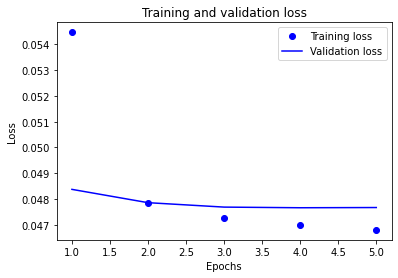

In [125]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

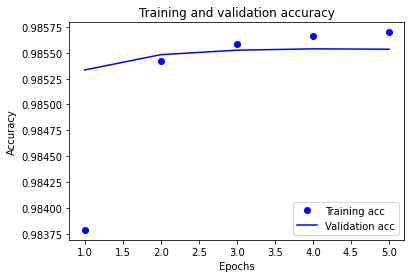

In [126]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# BLEU score on test dataset

In [127]:
# try model without training
scores = []
bi_scores = []

for input_test_batch, target_test_batch in test_dataset:
    test_batch_predictions = model(input_test_batch)
    scores.append(bleu_score(target_test_batch, test_batch_predictions))
    bi_scores.append(bleu_score_bi(target_test_batch, test_batch_predictions))

print("char bleu score: ",sum(scores)/len(scores))
print("bi-char bleu score:", sum(bi_scores)/len(bi_scores))

char bleu score:  0.15952141633003283
bi-char bleu score: 0.07182868431938888


# Inference

In [128]:
class OneStep(tf.keras.Model):
  def __init__(self, model, tokenizer, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.tokenizer = tokenizer

  #@tf.function
  def generate_one_step(self, input_chars, states=None):
    #import pdb; pdb.set_trace()
    # Convert strings to token IDs.
    # input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.tokenizer.texts_to_sequences(input_chars)
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, padding='post')

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, f_states_h, f_states_c, b_states_h, b_states_c = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.tokenizer.sequences_to_texts([predicted_ids.numpy()])

    # Return the characters and model state.
    return predicted_chars, [f_states_h, f_states_c, b_states_h, b_states_c]

In [129]:
one_step_model = OneStep(model, tokenizer)

In [130]:
start = time.time()
states = None
next_char = ['w']
result = [next_char]

for n in range(2):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

www 

________________________________________________________________________________

Run time: 0.1072075366973877


In [131]:
def pwds_from_chars(start_char, len):
  states = None
  next_char = [start_char]
  result = [next_char]

  for n in range(len-1):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

  result = tf.strings.join(result)
  return result[0].numpy().decode('utf-8')

In [132]:
all_pos = []
while True:
  pred = pwds_from_chars('p', 4)
  if pred not in all_pos:
    all_pos.append(pred)
  else:
    break

print(all_pos)

['pjpj', 'p&p&', 'pppp']


In [133]:
given_pass = 'Password1'
attempts = 1

while True:
  pred = pwds_from_chars(given_pass[0], len(given_pass))
  print(f"{attempts} - {pred}")
  if pred == given_pass:
    break
  attempts += 1

print(f"Model took {attempts} attempts to find password - {given_pass}")

1 - PPPPPPPPP
2 - PPPPPPPPP
3 - PPPPPPPPP
4 - PpPpPpPpP
5 - PPPPPPPPP
6 - PPPPPPPPP
7 - PPPPPPPPP
8 - P&P&P&P&P
9 - PPPPPPPPP
10 - PPPPPPPPP
11 - PCPCPCPCP
12 - P&P&P&P&P
13 - P&P&P&P&P
14 - PPPPPPPPP
15 - PPPPPPPPP
16 - P{P{P{P{P
17 - PGPGPGPGP
18 - PPPPPPPPP
19 - PPPPPPPPP
20 - PUPUPUPUP
21 - P:P:P:P:P
22 - PPPPPPPPP
23 - PPPPPPPPP
24 - PPPPPPPPP
25 - PPPPPPPPP
26 - P&P&P&P&P
27 - PPPPPPPPP
28 - PPPPPPPPP
29 - P"P"P"P"P
30 - P&P&P&P&P
31 - P&P&P&P&P
32 - PPPPPPPPP
33 - PCPCPCPCP
34 - PPPPPPPPP
35 - PPPPPPPPP
36 - P&P&P&P&P
37 - PPPPPPPPP
38 - PCPCPCPCP
39 - PPPPPPPPP
40 - PCPCPCPCP
41 - PIPIPIPIP
42 - P<P<P<P<P
43 - PMPMPMPMP
44 - P&P&P&P&P
45 - PPPPPPPPP
46 - PFPFPFPFP
47 - PCPCPCPCP
48 - PPPPPPPPP
49 - PPPPPPPPP
50 - PCPCPCPCP
51 - PFPFPFPFP
52 - PPPPPPPPP
53 - P&P&P&P&P
54 - P&P&P&P&P
55 - P&P&P&P&P
56 - PPPPPPPPP
57 - PCPCPCPCP
58 - PPPPPPPPP
59 - P&P&P&P&P
60 - PCPCPCPCP
61 - P&P&P&P&P
62 - PPPPPPPPP
63 - PPPPPPPPP
64 - PBPBPBPBP
65 - PPPPPPPPP
66 - PCPCPCPCP
67 - PPPPPPPPP
68 -

KeyboardInterrupt: ignored

# Attempts calculation

In [ ]:
def find_attempts(given_pwd):
  pass_len = len(given_pwd)
  attempts = 1
  # iterate through each starting letter. 
  for l in tokenizer.word_index.keys():
    states = None
    next_char = [l]
    result = [next_char]

    for n in range(pass_len-1):
      next_char, states = one_step_model.generate_one_step(next_char, states=states)
      result.append(next_char)
    
    result = tf.strings.join(result)
    pred = result[0].numpy().decode('utf-8')
    if pred == given_pwd:
      print(f"Model predicted password in {attempts}")
    else:
      attempts += 1

In [ ]:
find_attempts('war')

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

reference = [['a', 'b', 'c'], ['p','q','r'],[' ']]
candidate = [['a', 'b', 'c'], ['p','q','r'],[' ']]

score = corpus_bleu(reference, candidate)
print(score)

1.0


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
reference = [['a', 'b', 'c'], ['p','q','r'],[' ']]
candidate = [['p','q','r'],['a', 'b', 'c'],[' ']]

score = corpus_bleu(reference, candidate)
print(score)

0.6147881529512643


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
reference = [['a', 'b', 'c'], ['p','q','r'],[' ']]
candidate = [['a', 'b', 'd'], ['p','q','r'],[' ']]

score = corpus_bleu(reference, candidate)
print(score)

0.9621954581957615


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
